In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import joblib
import torch.optim as optim
from utils import train_and_get_losses, plot_learning_curve
from math import sqrt

In [3]:
df = pd.read_csv("../data/cleaned_data.csv")
scaler = joblib.load("../scalers/minmax.save")

## Splitting data, converting to tensors

In [4]:
bool_columns = df.select_dtypes(include='bool').columns
df[bool_columns] = df[bool_columns].astype(int)

X = df.drop('price', axis=1).values 
y = df['price'].values

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

/tmp/ipykernel_4882/3186168220.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
/tmp/ipykernel_4882/3186168220.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)


## Defining model architecture

In [5]:
class NeuralNetwork1(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork1, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x
    
class NeuralNetwork2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork2, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        return x

## Initializing the model

In [6]:
input_size = X_train.shape[1]
hidden_size = 128
output_size = 1  

model = NeuralNetwork1(input_size, hidden_size, output_size)

In [7]:
model = NeuralNetwork2(input_size, hidden_size, output_size)

## Hyperparameters

In [8]:
learning_rate = 0.004
criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=learning_rate) 

num_epochs = 100
batch_size = 32
train_losses = [] 
test_losses = []  

## Training loop + eval

Epoch [1/100], Training Loss: 491052.0969655234, Test Loss: 18672136.0
Epoch [2/100], Training Loss: 487559.3987545169, Test Loss: 18574988.0
Epoch [3/100], Training Loss: 484135.5487900598, Test Loss: 18479642.0
Epoch [4/100], Training Loss: 480801.4097802263, Test Loss: 18389318.0
Epoch [5/100], Training Loss: 477528.1247334281, Test Loss: 18300152.0
Epoch [6/100], Training Loss: 474328.2147532729, Test Loss: 18218262.0
Epoch [7/100], Training Loss: 471187.35348172503, Test Loss: 18131248.0
Epoch [8/100], Training Loss: 468110.31100793794, Test Loss: 18053026.0
Epoch [9/100], Training Loss: 465088.11595136544, Test Loss: 17972568.0
Epoch [10/100], Training Loss: 462135.5946922576, Test Loss: 17899206.0
Epoch [11/100], Training Loss: 459228.54234050115, Test Loss: 17824552.0
Epoch [12/100], Training Loss: 456388.01785291155, Test Loss: 17757568.0
Epoch [13/100], Training Loss: 453591.4684778745, Test Loss: 17686360.0
Epoch [14/100], Training Loss: 450855.9832948285, Test Loss: 1762355

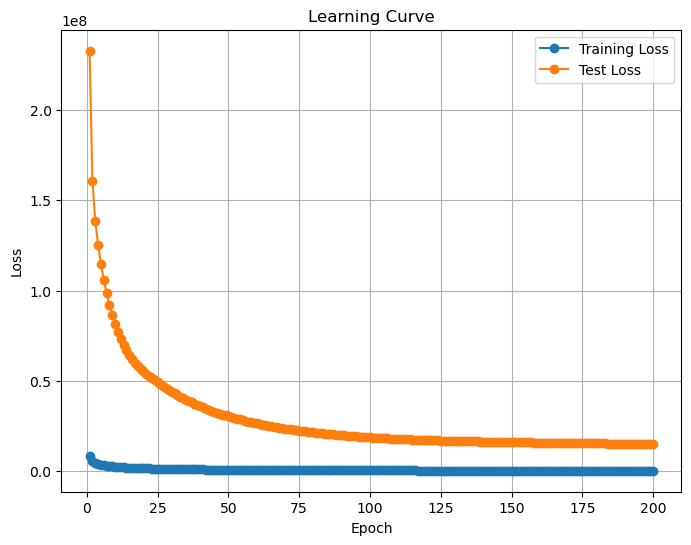

In [11]:
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]

        optimizer.zero_grad()  
        outputs = model(batch_X)  
        loss = criterion(outputs, batch_y.view(-1, 1)) 

        loss.backward()  
        optimizer.step() 

        epoch_loss += loss.item()


    with torch.no_grad():
        model.eval()
        test_outputs = model(X_test)
        loss = criterion(test_outputs, y_test.view(-1, 1))
        model.train()

    train_losses.append(epoch_loss / len(X_train))
    test_losses.append(loss.item())

    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {train_losses[-1]}, Test Loss: {test_losses[-1]}')

print(f"Train RMSE : {sqrt(train_losses[-1])}, Test RMSE : {sqrt(test_losses[-1])}")

plot_learning_curve(train_losses, test_losses)

## Testing different learning rate + batch size combinations

In [26]:
lr_vals = [0.1, 0.001, 0.2, 0.002, 0.3, 0.003, 0.4, 0.004]
batch_vals = [32, 64, 128, 211, 256, 512]
res_rmse = {}

In [28]:
input_size = X_train.shape[1]
hidden_size = 128
output_size = 1  

for lr in lr_vals:
    for batch in batch_vals:
        model = NeuralNetwork(input_size, hidden_size, output_size)
        res = train_and_get_losses(lr, batch, model, X_train, X_test, y_train, y_test)
        res_rmse[(lr,batch)] = res[1][-1]

In [30]:
for comb in res_rmse:
    res_rmse[comb] = sqrt(res_rmse[comb])

In [32]:
sorted_dict = dict(sorted(res_rmse.items(), key=lambda item: item[1]))

In [33]:
sorted_dict

{(0.004, 32): 3661.9059245152653,
 (0.002, 32): 3668.066384350207,
 (0.001, 32): 3669.345309452355,
 (0.1, 32): 3674.1856240533084,
 (0.4, 32): 3679.356737257207,
 (0.2, 32): 3679.964266130855,
 (0.3, 32): 3688.413615634776,
 (0.003, 32): 3695.299446594281,
 (0.002, 64): 3721.2899645149932,
 (0.003, 64): 3739.222111616265,
 (0.004, 64): 3739.4598540430943,
 (0.1, 64): 3743.0721339562774,
 (0.3, 64): 3743.1792636741297,
 (0.4, 64): 3746.1737813401023,
 (0.2, 64): 3750.3058541937617,
 (0.001, 64): 3752.4312118944968,
 (0.1, 128): 3972.7842881284155,
 (0.3, 128): 3986.4845415478535,
 (0.001, 128): 3986.8656862252083,
 (0.2, 128): 3989.9437339391143,
 (0.002, 128): 3990.0556387098163,
 (0.004, 128): 3995.3310250841546,
 (0.003, 128): 4014.529735847027,
 (0.4, 128): 4059.343666160824,
 (0.001, 256): 4692.576264697251,
 (0.1, 256): 4707.039196777524,
 (0.4, 256): 4707.984282046829,
 (0.004, 256): 4722.7813838881,
 (0.2, 256): 4727.638734082798,
 (0.3, 256): 4738.234692372255,
 (0.003, 256): 

## Making predictions

In [ ]:
data = transform_raw_input_to_df("Opel", "Insignia", "2.0D", 2010, 239000, df_mean, sc_mean)
with torch.no_grad():
    inputs = torch.tensor(data, dtype=torch.float32)
    predictions = model.eval(inputs).numpy()

## Saving weights

In [ ]:
torch.save(model.state_dict, '../weights/model_nonans.0.0.1.pth')

In [ ]:
_